# Variational AutoEncoder



## 0. imports

In [1]:
%load_ext jupyter_black

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from tqdm.auto import trange

## 1. VAE

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = torch.sigmoid(h)
        return x_hat


def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction="sum")
        L2 = -torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)

        return (L1 + L2) / batch_size

## 2. Train

In [6]:
# hyperparameters
input_dim = 784  # x dimension
hidden_dim = 200  # neurons in hidden layers
latent_dim = 20  # z dimension
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [11]:
# datasets
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(torch.flatten)]  # falatten
)
dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/30 [00:00<?, ?it/s]

53.91700521036784
45.07360242919922
43.18751365356445
42.12366832885742
41.38637775268555
40.90727807210286
40.56706199544271
40.332074346923825
40.112829416910806
39.93841025594075
39.826220963541665
39.70203022867839
39.59999764404297
39.4924157023112
39.41998460083008
39.33572902018229
39.27312371317546
39.20360844116211
39.106714471435545
39.04270173950195
39.00508039347331
38.93652414042155
38.874490594482424
38.85062456665039
38.74040512898763
38.7466863647461
38.707560513305665
38.66687666625977
38.6491407023112
38.572851936848956


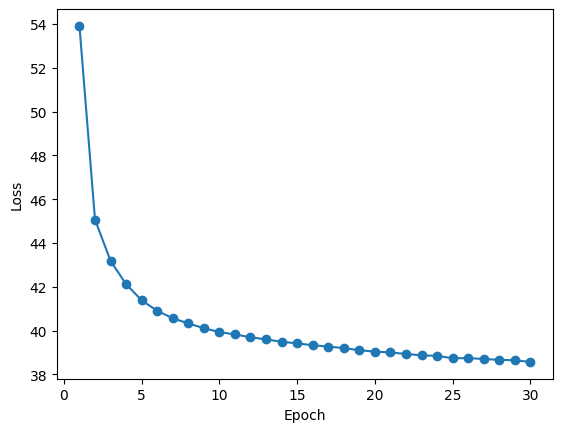

In [13]:
for epoch in trange(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        x, label = x.to(device), label.to(device)
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)

# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

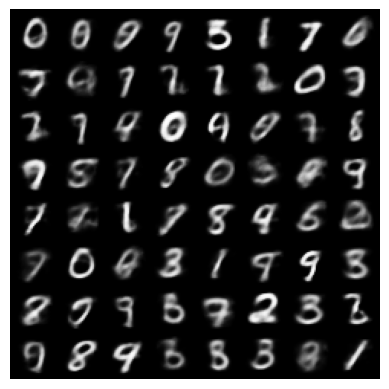

In [16]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z.to(device))
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images, nrow=8, padding=2, normalize=True
)
grid_img = grid_img.to("cpu")
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.show()